In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy
import collections
import sys, os, re
import predict_severity
import numpy as np
import skimage
import severity_utils
import pickle
import torch, torchvision
import torch.nn.functional as F

In [3]:
sys.path.insert(0,"../torchxrayvision")
import torchxrayvision as xrv

In [4]:
import torchvision, torchvision.transforms
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

In [5]:
# https://doi.org/10.5281/zenodo.4633999
dataset = xrv.datasets.StonyBrookCOVID_Dataset(imgpath="CXR_images_scored/",
                                               csvpath="ralo-dataset-metadata.csv",
                                               transform=transform)

In [6]:
if not os.path.exists("extracted_features.pkl"):
    
    nn_model = xrv.models.DenseNet(weights="all")#.cuda()
    nn_model.op_threshs = None # to prevent sigmoid

    dl = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=0)
    feats = []
    preds = []
    with torch.no_grad():
        for i, batch in enumerate(dl):
            imgs = batch["img"]#.cuda()
            out = nn_model.features(imgs)
            out = F.relu(out, inplace=True)
            out = F.adaptive_avg_pool2d(out, (1, 1))
            pred = nn_model(imgs)
            feats.append(out.detach().cpu().numpy())
            preds.append(pred.detach().cpu().numpy())
            if i %10 == 0:
                print(i)
    feats = np.concatenate(d_feats).reshape(-1,1024)
    preds = np.concatenate(d_preds)
    
    pickle.dump((feats, preds), open("extracted_features.pkl", "bw"))
    
feats, preds = pickle.load(open("extracted_features.pkl", "br"))
    

In [7]:
print(preds.shape)
print(feats.shape)

(2373, 18)
(2373, 1024)


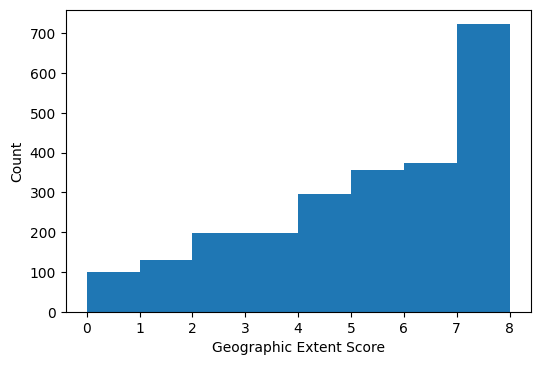

In [8]:
plt.subplots(figsize=(6,4), dpi=100)
plt.hist(dataset.csv["Geographic Extent"], bins=8);
plt.xlabel("Geographic Extent Score")
plt.ylabel("Count")
plt.xticks(range(9));

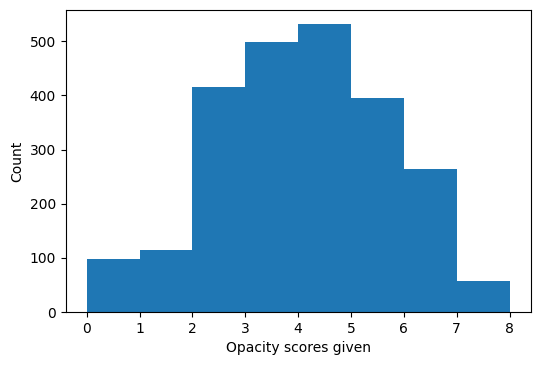

In [9]:
plt.subplots(figsize=(6,4), dpi=100)
plt.hist(dataset.csv["Lung Opacity"], bins=8);
plt.xlabel("Opacity scores given")
plt.ylabel("Count")
plt.xticks(range(9));

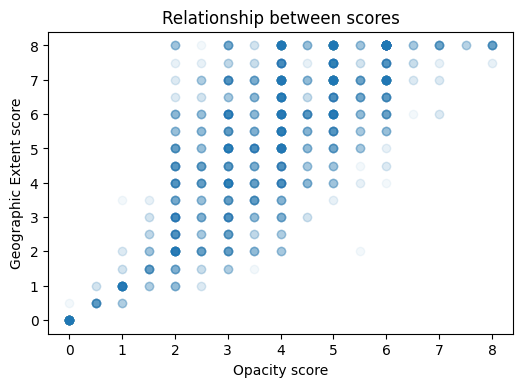

In [10]:
plt.subplots(figsize=(6,4), dpi=100)
plt.scatter(dataset.csv["Lung Opacity"], dataset.csv["Geographic Extent"], alpha=0.05)
plt.xlabel("Opacity score")
plt.ylabel("Geographic Extent score")
plt.title("Relationship between scores")
plt.xticks(range(9));
plt.yticks(range(9));

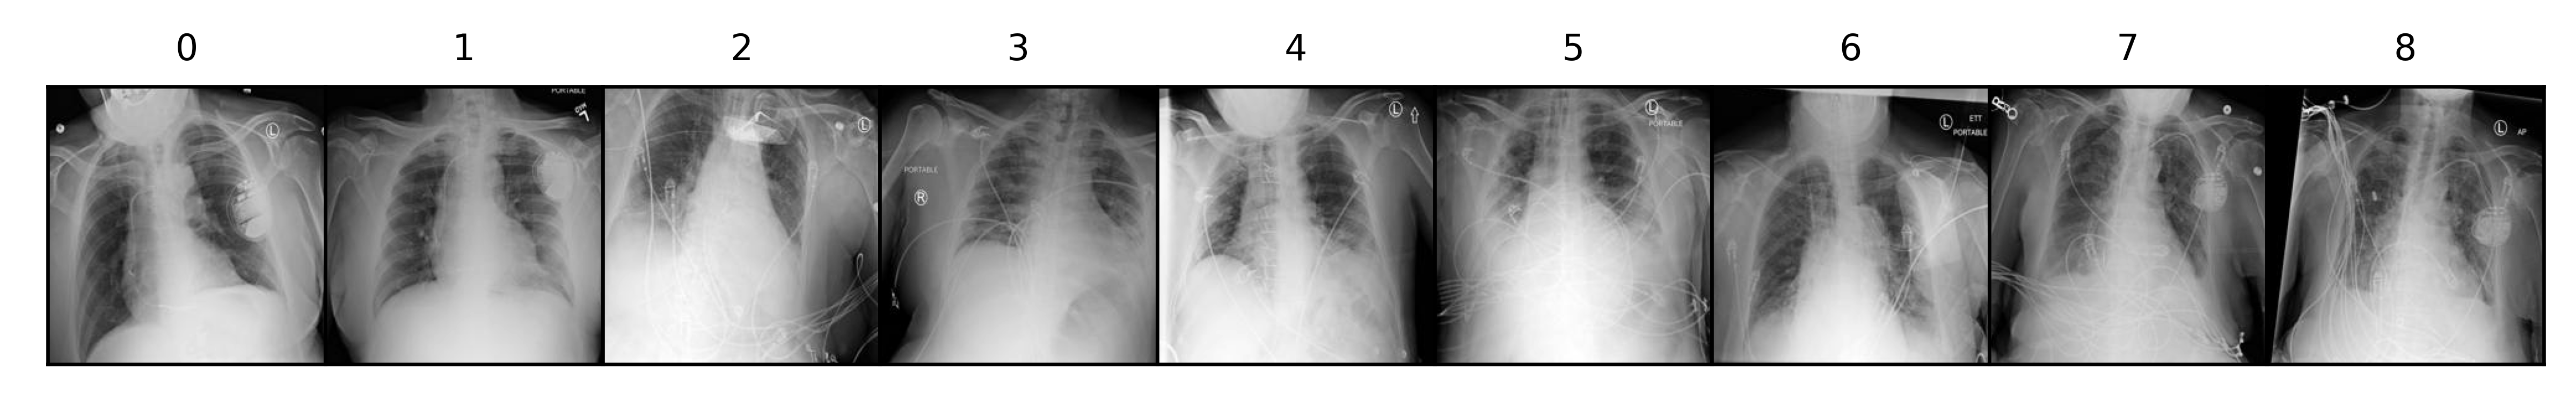

In [11]:
fig, ax = plt.subplots(1,9, figsize=(10,4), dpi=600)
for i in range(9):
    img_id = np.where(dataset.csv["Geographic Extent"] == i)[0][1]
    img = dataset[img_id]["img"][0]
    ax[i].imshow(img, cmap="gray")
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(i, fontsize=8)
plt.subplots_adjust(wspace=0)

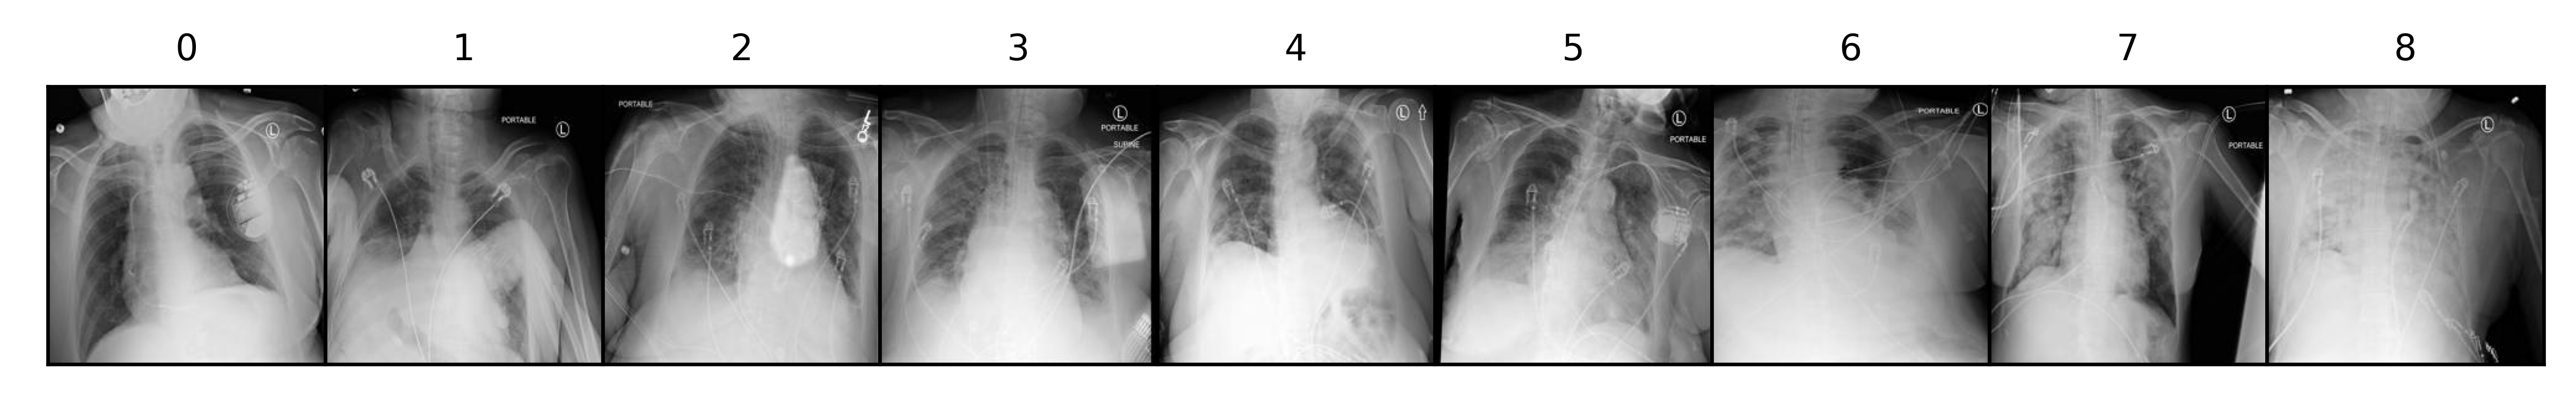

In [12]:
fig, ax = plt.subplots(1,9, figsize=(10,4), dpi=600)
for i in range(9):
    img_id = np.where(dataset.csv["Lung Opacity"] == i)[0][1]
    img = dataset[img_id]["img"][0]
    ax[i].imshow(img, cmap="gray")
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(i, fontsize=8)
plt.subplots_adjust(wspace=0)

In [13]:
#cache = pickle.load(open("cache.pkl","rb"))
cache = {}

Writing weights to weights/mlp_geo.pkl


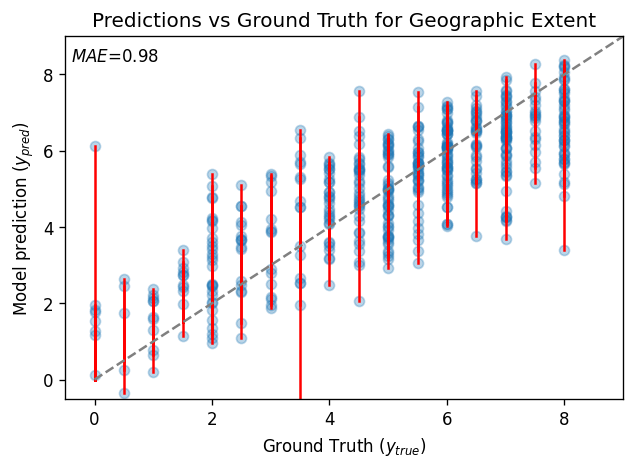

0.98±0.79


In [16]:
labels = dataset.csv["Geographic Extent"]
data = feats
a = severity_utils.evaluate(data, labels,"Predictions vs Ground Truth for Geographic Extent",
                            seed=1, cache=cache, save_weights="weights/mlp_geo.pkl")
print("{:1.2f}±{:1.2f}".format(a["MAE"], a["MAE_STDEV"]))

In [ ]:
labels = dataset.csv["Lung Opacity"]
data = feats
a = severity_utils.evaluate(data, labels,"Predictions vs Ground Truth for Opacity", 
                            seed=1, cache=cache, save_weights="weights/mlp_opa.pkl")
print("{:1.2f}±{:1.2f}".format(a["MAE"], a["MAE_STDEV"]))

In [ ]:
results = []
def kw(**kwargs):
    return kwargs

common_args = kw(seed=1,
               cache=cache,
               plot=False)


In [ ]:
labels = dataset.csv["Geographic Extent"]
data = feats
a = severity_utils.evaluate(data, labels, label_name="Geographic Extent",title="Feature Vector", **common_args)
results.append(a)
print("{:1.2f}±{:1.2f}".format(a["MAE"], a["MAE_STDEV"]))

In [ ]:
labels = dataset.csv["Geographic Extent"]
data = preds
a = severity_utils.evaluate(data, labels, label_name="Geographic Extent",title="18 Outputs", **common_args)
results.append(a)
print("{:1.2f}±{:1.2f}".format(a["MAE"], a["MAE_STDEV"]))

In [ ]:
labels = dataset.csv["Geographic Extent"]
data = preds
data = data[:,[xrv.datasets.default_pathologies.index("Lung Opacity")]]
a = severity_utils.evaluate(data, labels, label_name="Geographic Extent",title="1 Output", **common_args)
results.append(a)
print("{:1.2f}±{:1.2f}".format(a["MAE"], a["MAE_STDEV"]))

In [ ]:
labels = dataset.csv["Geographic Extent"]
data = preds
data = data[:,[xrv.datasets.default_pathologies.index("Lung Opacity")]]
a = severity_utils.evaluate(data, labels, label_name="Geographic Extent",title="1 Output", method="lr", **common_args)
results.append(a)
print("{:1.2f}±{:1.2f}".format(a["MAE"], a["MAE_STDEV"]))

In [ ]:
labels = dataset.csv["Lung Opacity"]
data = feats
a = severity_utils.evaluate(data, labels, label_name="Lung Opacity",title="Feature Vector", **common_args)
results.append(a)
print("{:1.2f}±{:1.2f}".format(a["MAE"], a["MAE_STDEV"]))

In [ ]:
labels = dataset.csv["Lung Opacity"]
data = preds
a = severity_utils.evaluate(data, labels, label_name="Lung Opacity",title="18 Outputs", **common_args)
results.append(a)
print("{:1.2f}±{:1.2f}".format(a["MAE"], a["MAE_STDEV"]))

In [ ]:
labels = dataset.csv["Lung Opacity"]
data = preds
data = data[:,[xrv.datasets.default_pathologies.index("Lung Opacity")]]
a = severity_utils.evaluate(data, labels, label_name="Lung Opacity",title="1 Output", **common_args)
results.append(a)
print("{:1.2f}±{:1.2f}".format(a["MAE"], a["MAE_STDEV"]))

In [ ]:
labels = dataset.csv["Lung Opacity"]
data = preds[:,[xrv.datasets.default_pathologies.index("Lung Opacity")]]
a = severity_utils.evaluate(data, labels, label_name="Lung Opacity",title="1 Output", method="lr", **common_args)
results.append(a)
print("{:1.2f}±{:1.2f}".format(a["MAE"], a["MAE_STDEV"]))

In [101]:
a = pd.DataFrame(results).groupby(["label_name", "method", "name"])[["MAE","MAE_STDEV"]].first().round(2)
#a

In [102]:
pd.DataFrame(a["MAE"].apply("{0:0.2f}".format) + "±" + a["MAE_STDEV"].apply("{0:0.2f}".format))

0
label_name        method name                     
Geographic Extent lr     1 Output        1.21±0.94
                  nn     1 Output        1.13±0.94
                         18 Outputs      1.08±0.86
                         Feature Vector  0.98±0.80
Lung Opacity      lr     1 Output        0.90±0.64
                  nn     1 Output        0.89±0.64
                         18 Outputs      0.91±0.65
                         Feature Vector  0.88±0.64